# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>


In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [7]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [8]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [10]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [11]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [12]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Посмотрим, как выглядят распределения числовых признаков:

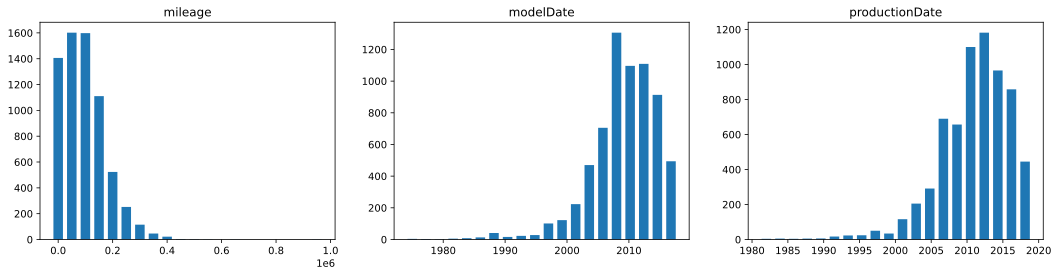

In [13]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [14]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


# Проведем более детальный анализ признаков


In [15]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   object 
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

Данные с пропусками только по признакам "Владение" и "Владельцы". Заполним "Владельцы" самым популярным значением. "Владение" не будем брать в модель, так как заполнение всего 35%

Пропишу признаки, по которым были внесены изменения

# 1.Владельцы

In [16]:
data['Владельцы'].value_counts()

3 или более    3311
1 владелец     2526
2 владельца    2515
Name: Владельцы, dtype: int64

In [17]:
data.loc[data['Владельцы'].isna()==True, 'Владельцы'] = '3 или более'
data['Владельцы'].value_counts()

3 или более    3312
1 владелец     2526
2 владельца    2515
Name: Владельцы, dtype: int64

# 2.engineDisplacement

In [18]:
data['engineDisplacement'].value_counts()

2.0 LTR          2430
3.0 LTR          2349
1.8 LTR           411
1.6 LTR           410
4.4 LTR           329
5.5 LTR           268
3.5 LTR           250
2.5 LTR           248
2.1 LTR           221
4.0 LTR           153
4.7 LTR           137
1.4 LTR           106
2.8 LTR           106
4.2 LTR           103
5.0 LTR            74
1.5 LTR            73
3.2 LTR            60
2.2 LTR            58
4.8 LTR            57
2.9 LTR            50
3.1 LTR            44
2.4 LTR            44
6.2 LTR            40
6.0 LTR            37
5.4 LTR            33
1.2 LTR            33
1.3 LTR            32
2.7 LTR            24
3.6 LTR            23
4.1 LTR            23
1.7 LTR            15
3.7 LTR            14
2.3 LTR            14
5.2 LTR            13
5.9 LTR            11
2.6 LTR             9
undefined LTR       6
0.7 LTR             6
5.8 LTR             5
6.6 LTR             5
4.6 LTR             5
1.9 LTR             5
4.3 LTR             4
3.4 LTR             4
6.3 LTR             3
5.6 LTR   

Видим, что не определены часть значений. Заменим из на самое популярное
Переведём это поле в числовое

In [19]:
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: '2.0 LTR' if x == 'undefined LTR' else x)
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: (x.split(' ')[0].replace('.', '')))
data['engineDisplacement'] = data['engineDisplacement'].astype('int')
data['engineDisplacement'].value_counts()

20    2436
30    2349
18     411
16     410
44     329
55     268
35     250
25     248
21     221
40     153
47     137
14     106
28     106
42     103
50      74
15      73
32      60
22      58
48      57
29      50
24      44
31      44
62      40
60      37
54      33
12      33
13      32
27      24
36      23
41      23
17      15
23      14
37      14
52      13
59      11
26       9
7        6
58       5
66       5
19       5
46       5
34       4
43       4
56       3
38       3
63       3
49       2
Name: engineDisplacement, dtype: int64

# 3.enginePower

In [20]:
data['enginePower'].value_counts()

184 N12    759
249 N12    655
190 N12    420
245 N12    355
306 N12    344
          ... 
329 N12      1
165 N12      1
430 N12      1
321 N12      1
700 N12      1
Name: enginePower, Length: 154, dtype: int64

Переведём это поле в числовое

In [21]:
data['enginePower'] = data['enginePower'].str.split().apply(lambda x: x[0]) 
data['enginePower'] = data['enginePower'].apply(lambda x: int(x))

In [22]:
data['enginePower'].value_counts()

184    759
249    655
190    420
245    355
306    344
      ... 
132      1
457      1
591      1
114      1
100      1
Name: enginePower, Length: 154, dtype: int64

# 4.mileage

In [23]:
data['mileage'].value_counts()

120000    79
150000    79
180000    77
130000    70
140000    62
          ..
107800     1
80250      1
373        1
41329      1
102402     1
Name: mileage, Length: 3507, dtype: int64

In [24]:
data['mileage'].describe()

count       8353.000000
mean      120362.983479
std        81856.639133
min            1.000000
25%        59246.000000
50%       110384.000000
75%       167084.000000
max      1000000.000000
Name: mileage, dtype: float64

очень большой разброс по значениям. Сделаю как в модуле 5 - поделю на категории в зависимости от пробега

In [25]:
def mile_age(x):
    if x < 20000: x = 1
    elif 19999 < x < 40000: x = 2
    elif 39999 < x < 60000: x = 3
    elif 59999 < x < 80000: x = 4
    elif 79999 < x < 100000: x = 5
    elif 99999 < x < 200000: x = 6
    elif 199999 < x < 500000: x = 7
    elif 499999 < x: x = 8
    return x  
data['mileage_category'] = data['mileage'].map(mile_age)

In [26]:
data['mileage_category'].value_counts()

6    3361
7    1246
5     868
4     767
1     753
3     700
2     651
8       7
Name: mileage_category, dtype: int64

# 5.productionDate 

In [27]:
data['productionDate'].value_counts()

2013    783
2011    702
2014    693
2012    680
2016    600
2015    599
2017    562
2018    529
2008    510
2010    468
2019    449
2009    345
2007    343
2006    182
2005    170
2004    155
2020    100
2003    100
2002     78
2001     73
1999     45
2000     43
1998     24
1997     21
1994     15
1995     14
1992     12
1996     12
1993     12
1990     10
1985      4
1986      4
1988      4
1982      3
1984      3
1991      2
1983      2
1989      1
1987      1
Name: productionDate, dtype: int64

создадим новый признак Возраст машины (age_car)

In [28]:
data['age_car'] = data['productionDate'].apply(lambda x: 2021 - x)
data['age_car'].value_counts()

8     783
10    702
7     693
9     680
5     600
6     599
4     562
3     529
13    510
11    468
2     449
12    345
14    343
15    182
16    170
17    155
1     100
18    100
19     78
20     73
22     45
21     43
23     24
24     21
27     15
26     14
25     12
28     12
29     12
31     10
33      4
35      4
36      4
37      3
39      3
38      2
30      2
32      1
34      1
Name: age_car, dtype: int64

# 6.mileagePerYear

сделаем новый признак - пробег в год

In [29]:
data['mileagePerYear']=data['mileage']/data['age_car']

Пропишем категориальные и числовые признаки по группам

In [30]:
#categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'Владельцы', 
#                        'numberOfDoors', 'vehicleTransmission', 'ПТС', 'Привод', 'Руль']
#numerical_features = ['mileage', 'modelDate', 'productionDate', 'enginePower', 'engineDisplacement', 
#                      'age_car', 'mileagePerYear','mileage_category']
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'Владельцы', 
                        'numberOfDoors', 'vehicleTransmission', 'ПТС', 'Привод', 'Руль','mileage_category']
numerical_features = ['mileage', 'modelDate', 'productionDate', 'enginePower', 'engineDisplacement', 
                      'age_car', 'mileagePerYear']

In [31]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   int64  
 5   enginePower           8353 non-null   int64  
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

In [32]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id','vehicleConfiguration','name','Владение'], axis = 1, inplace=True)
    
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    #df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    
    return df_output

In [33]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,sample,price,age_car,mileagePerYear,bodyType_0,...,Руль_0,Руль_1,mileage_category_0,mileage_category_1,mileage_category_2,mileage_category_3,mileage_category_4,mileage_category_5,mileage_category_6,mileage_category_7
7399,0.220339,0.2720,0.106999,0.895833,0.868421,1,1590000.0,0.131579,0.231830,0,...,1,0,0,0,0,0,0,1,0,0
4273,0.220339,0.2720,0.044999,0.875000,0.894737,1,3100000.0,0.105263,0.116996,0,...,1,0,0,0,1,0,0,0,0,0
3362,0.813559,0.8160,0.054999,0.875000,0.868421,1,3750000.0,0.131579,0.119163,0,...,1,0,0,0,1,0,0,0,0,0
2794,0.389831,0.2720,0.124999,0.833333,0.763158,1,1990000.0,0.236842,0.162497,0,...,1,0,0,0,0,0,0,1,0,0
5378,0.220339,0.2288,0.148999,0.875000,0.868421,1,1285000.0,0.131579,0.322831,0,...,1,0,0,0,0,0,0,1,0,0
5902,0.559322,0.7760,0.069799,0.854167,0.815789,1,3399999.0,0.184211,0.113421,0,...,1,0,0,0,0,1,0,0,0,0
1454,0.389831,0.3920,0.052765,0.854167,0.868421,0,0.0,0.131579,0.114323,0,...,1,0,0,0,1,0,0,0,0,0
2476,0.305085,0.2288,0.173499,0.750000,0.684211,1,700000.0,0.315789,0.173497,0,...,1,0,0,0,0,0,0,1,0,0
743,0.152542,0.0640,0.119999,0.750000,0.736842,0,0.0,0.263158,0.141815,0,...,1,0,0,0,0,0,0,1,0,0
1168,0.813559,0.7504,0.035999,0.854167,0.842105,0,0.0,0.157895,0.066853,0,...,1,0,0,1,0,0,0,0,0,0


In [34]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 197 entries, engineDisplacement to mileage_category_7
dtypes: float64(8), int64(1), uint8(188)
memory usage: 2.1 MB


## Split data

In [35]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values
y_log = np.log(y)    # логарифмируем 

#y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [36]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 196 entries, engineDisplacement to mileage_category_7
dtypes: float64(8), uint8(188)
memory usage: 424.3 KB


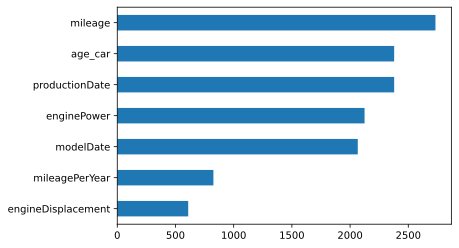

In [37]:
# Проверим их значимость
from sklearn.feature_selection import f_regression, mutual_info_regression
nums = pd.Series(f_regression(train_data[numerical_features], train_data['price'])[0], index = numerical_features)
nums.sort_values(inplace = True)
nums.plot(kind = 'barh')

# Model 2: CatBoostRegressor

In [38]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [39]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          learning_rate = 0.025,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

0:	learn: 0.0418309	test: 0.0419013	best: 0.0419013 (0)	total: 52.5ms	remaining: 4m 22s
100:	learn: 0.0125912	test: 0.0122505	best: 0.0122505 (100)	total: 461ms	remaining: 22.4s
200:	learn: 0.0102584	test: 0.0099894	best: 0.0099894 (200)	total: 828ms	remaining: 19.8s
300:	learn: 0.0096524	test: 0.0094820	best: 0.0094820 (300)	total: 1.22s	remaining: 19.1s
400:	learn: 0.0092716	test: 0.0092129	best: 0.0092129 (400)	total: 1.61s	remaining: 18.5s
500:	learn: 0.0089565	test: 0.0089854	best: 0.0089854 (500)	total: 2.02s	remaining: 18.2s
600:	learn: 0.0086029	test: 0.0087287	best: 0.0087287 (600)	total: 2.42s	remaining: 17.7s
700:	learn: 0.0083101	test: 0.0085251	best: 0.0085245 (699)	total: 2.81s	remaining: 17.3s
800:	learn: 0.0080482	test: 0.0083621	best: 0.0083621 (800)	total: 3.22s	remaining: 16.9s
900:	learn: 0.0078459	test: 0.0082521	best: 0.0082521 (900)	total: 3.63s	remaining: 16.5s
1000:	learn: 0.0076732	test: 0.0081600	best: 0.0081594 (999)	total: 4.04s	remaining: 16.1s
1100:	learn

In [40]:
test_predict_catboost = model.predict(X_test)
test_predict_catboost_reg = np.exp(test_predict_catboost)
y_test_reg = np.exp(y_test)
print(f"TEST mape: {(mape(y_test_reg, test_predict_catboost_reg))*100:0.4f}%")

TEST mape: 11.0645%


# Улучшили результат

### Submission

In [41]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [43]:
X_train.head(5)

## Simple Dense NN

In [44]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [45]:
model.summary()

In [46]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [47]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [48]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

In [49]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [50]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [51]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

In [52]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

# Model 4: NLP + Multiple Inputs

с подсказкой из https://habr.com/ru/company/Voximplant/blog/446738/

In [53]:
data.description

In [54]:
!pip install pymystem3

import nltk
from pymystem3 import Mystem
from nltk.stem import WordNetLemmatizer

In [55]:
mystem = Mystem() 
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
def lemma_text(text):
    text = re.sub(patterns, ' ', text)
    tokens = mystem.lemmatize(text.lower())
    text = " ".join(tokens)
    
    return text

In [56]:
data.description = data.description.apply(lambda x: lemma_text(x))
data.description[5]

In [57]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [58]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [59]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [60]:
tokenize.word_index

In [61]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

In [62]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

### RNN NLP

In [63]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [64]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [65]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [66]:
model.summary()

### Fit

In [67]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [68]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [69]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

In [70]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [71]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [72]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

In [73]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

In [74]:
# убедимся, что цены и фото подгрузились верно
#plt.figure(figsize = (12,8))

#random_image = train.sample(n = 9)
#random_image_paths = random_image['sell_id'].values
#random_image_cat = random_image['price'].values

#for index, path in enumerate(random_image_paths):
#    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
#    plt.subplot(3, 3, index + 1)
#    plt.imshow(im)
#    plt.title('price: ' + str(random_image_cat[index]))
#    plt.axis('off')
#plt.show()

In [75]:
#size = (320, 240)

#def get_image_array(index):
#    images_train = []
#    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
#        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
#        assert(image is not None)
##        image = cv2.resize(image, size)
#        images_train.append(image)
#    images_train = np.array(images_train)
#    print('images shape', images_train.shape, 'dtype', images_train.dtype)
#    return(images_train)

#images_train = get_image_array(X_train.index)
#images_test = get_image_array(X_test.index)
#images_sub = get_image_array(X_sub.index)

### albumentations

In [76]:
#from albumentations import (
#    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
#    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
#    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
#    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
#)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
#augmentation = Compose([
#    HorizontalFlip(),
#    OneOf([
#        IAAAdditiveGaussianNoise(),
#        GaussNoise(),
 #   ], p=0.2),
#    OneOf([
#        MotionBlur(p=0.2),
#        MedianBlur(blur_limit=3, p=0.1),
#        Blur(blur_limit=3, p=0.1),
#    ], p=0.2),
#    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
#    OneOf([
#        OpticalDistortion(p=0.3),
#        GridDistortion(p=0.1),
#        IAAPiecewiseAffine(p=0.3),
#    ], p=0.2),
#    OneOf([
#        CLAHE(clip_limit=2),
#        IAASharpen(),
#        IAAEmboss(),
#        RandomBrightnessContrast(),
#    ], p=0.3),
#    HueSaturationValue(p=0.3),
#], p=1)

#пример
#plt.figure(figsize = (12,8))
#for i in range(9):
#    img = augmentation(image = images_train[0])['image']
#    plt.subplot(3, 3, i + 1)
#    plt.imshow(img)
#    plt.axis('off')
#plt.show()

In [77]:
#def make_augmentations(images):
#  print('применение аугментаций', end = '')
#  augmented_images = np.empty(images.shape)
#  for i in range(images.shape[0]):
#    if i % 200 == 0:
#      print('.', end = '')
#    augment_dict = augmentation(image = images[i])
#    augmented_image = augment_dict['image']
#    augmented_images[i] = augmented_image
#  print('')
#  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [78]:
# NLP part
#tokenize = Tokenizer(num_words=MAX_WORDS)
#tokenize.fit_on_texts(data.description)

In [79]:
#def process_image(image):
#    return augmentation(image = image.numpy())['image']

#def tokenize_(descriptions):
#  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

#def tokenize_text(text):
#    return tokenize_([text.numpy().decode('utf-8')])[0]

#def tf_process_train_dataset_element(image, table_data, text, price):
#    im_shape = image.shape
#    [image,] = tf.py_function(process_image, [image], [tf.uint8])
#    image.set_shape(im_shape)
#    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
#    return (image, table_data, text), price

#def tf_process_val_dataset_element(image, table_data, text, price):
#    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
#    return (image, table_data, text), price

#train_dataset = tf.data.Dataset.from_tensor_slices((
#    images_train, X_train, data.description.iloc[X_train.index], y_train
#    )).map(tf_process_train_dataset_element)

#test_dataset = tf.data.Dataset.from_tensor_slices((
#    images_test, X_test, data.description.iloc[X_test.index], y_test
#    )).map(tf_process_val_dataset_element)

#y_sub = np.zeros(len(X_sub))
#sub_dataset = tf.data.Dataset.from_tensor_slices((
#    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
#    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
#train_dataset.__iter__().__next__();
#test_dataset.__iter__().__next__();
#sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [80]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
#efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
#efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [81]:
#строим нейросеть для анализа табличных данных
#tabular_model = Sequential([
#    L.Input(shape = X.shape[1]),
#    L.Dense(512, activation = 'relu'),
#    L.Dropout(0.5),
#    L.Dense(256, activation = 'relu'),
#    L.Dropout(0.5),
#    ])

In [82]:
# NLP
#nlp_model = Sequential([
#    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
#    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
#    L.LSTM(256, return_sequences=True),
#    L.Dropout(0.5),
#    L.LSTM(128),
#    L.Dropout(0.25),
#    L.Dense(64),
#    ])

In [83]:
#объединяем выходы трех нейросетей
#combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
#head = L.Dense(256, activation="relu")(combinedInput)
#head = L.Dense(1,)(head)

#model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
#model.summary()

In [84]:
#optimizer = tf.keras.optimizers.Adam(0.005)
#model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [85]:
#checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
#earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
#callbacks_list = [checkpoint, earlystop]

In [86]:
#history = model.fit(train_dataset.batch(30),
#                    epochs=5,
#                    validation_data = test_dataset.batch(30),
#                    callbacks=callbacks_list
#                   )

In [87]:
#plt.title('Loss')
#plt.plot(history.history['MAPE'], label='train')
#plt.plot(history.history['val_MAPE'], label='test')
#plt.show();

In [88]:
#model.load_weights('../working/best_model.hdf5')
#model.save('../working/nn_final.hdf5')

In [89]:
#test_predict_nn3 = model.predict(test_dataset.batch(30))
#print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

In [90]:
#sub_predict_nn3 = model.predict(sub_dataset.batch(30))
#sample_submission['price'] = sub_predict_nn3[:,0]
#sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [91]:
#blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
#print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

In [92]:
#blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
#sample_submission['price'] = blend_sub_predict
#sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [93]:
# MLP
#model_mlp = Sequential()
#model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
#model_mlp.add(L.Dropout(0.5))
#model_mlp.add(L.Dense(256, activation="relu"))
#model_mlp.add(L.Dropout(0.5))

In [94]:
# FEATURE Input
# Iput
#productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
#emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
#f_productiondate = L.Flatten()(emb_productiondate)

In [95]:
#combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
#head = L.Dense(64, activation="relu")(combinedInput)
#head = L.Dense(1, activation="linear")(head)

#model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [96]:
#model.summary()

In [97]:
#optimizer = tf.keras.optimizers.Adam(0.01)
#model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [98]:
#history = model.fit([X_train, X_train.productionDate.values], y_train,
#                    batch_size=512,
#                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
#                    validation_data=([X_test, X_test.productionDate.values], y_test),
#                    callbacks=callbacks_list
#                   )

In [99]:
#model.load_weights('../working/best_model.hdf5')
#test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
#print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")